# Imports and Materials

In [1]:
import numpy as np
import pmag as pm
import tidy3d as td
from jmaps.journey import *
from jmaps.paths import GDS_Tidy3DPath
import matplotlib.pyplot as plt
from tidy3d.plugins.resonance import ResonanceFinder

material_list = ['diamond', 'nitride', 'oxide']
if 'mats' in dir() and np.all([m in mats for m in material_list]):
    print("mats already defined")
else:
    mats = pm.materials.init_materials(material_list, plot=False)

materials_env = JEnv('materials', {
    'material_list' : JSet(material_list),
})

Initializing diamond material
Initializing nitride material
Initializing oxide material


# Journey

## Journey init

In [2]:
##################################################### GDS Device creation environments #####################################################
half_hybrid_env = JEnv('half_hybrid', {
    'left_periods' :    JSet(0),
    'right_periods' :   JSet(80),
})
full_hybrid_env = JEnv('full_hybrid', {
    'left_periods' :    JSet(80),
    'right_periods' :   JSet(80),
})
hybrid_env = JEnv('hybrid', {
    "a1" :              JVar(0.170), # central grating pitch
    "a2" :              JVar(0.1), # adiabatic taper pitch change
    "a3" :              JVar(80), # Number of periods to reach final pitch
    "a4" :              JSet(0.3), # SiN thickness
    "a5" :              JSet(0.5), # SiN duty cycle
    "b1" :              JVar(0.340), # diamond waveguide width
    "b4" :              JVar(0.100), # diamond waveguide height
    "center_over_rib" : JSet(True),
    "rib_length" :      JSet(6),
    "left_padding" :    JSet(4),
    "right_padding" :   JSet(4)
})

##################################################### Custom FDTD environments #####################################################
full_hybrid_fdtd_env = JEnv('full_hybrid_fdtd', {
    'inputs':      JSet({'o1': {
                        'modes': ['dipole_Ey'],
                        'amps': [1],
                        'phases': [0]
                        }
                   }),
    'outputs':     JSet({}),
    'z_monitor':   JSet('nitride'),
    'z_freq':      JSet(None),
    'z_thickness': JSet(0)
})

##################################################### Component creation environments #####################################################
layer_kwargs = {
    "oxide_thickness": 5,
    "nitride_thickness": hybrid_env['a4'].value,
    "diamond_thickness": hybrid_env['b4'].value
}
pdk = pm.pdks.get_hybrid_cav_pdk()
pdk.activate()
layer_stack = pm.layers.get_hybrid_layer_stack(**layer_kwargs)

component_env = JEnv('component', {
    'material_mapping': JOpt(mats),
    'pad_xy_inner':     JSet(0),
    'pad_xy_outer':     JSet(0),
    'pad_z_inner':      JSet(0),
    'pad_z_outer':      JSet(0),
    'extend_ports':     JSet(0),
    'port_offset':      JSet(0),
    'layer_stack':      JOpt(layer_stack),
})

##################################################### Modeler creation environments #####################################################
modeler_env = JEnv('modeler', {
    'center_z':       JSet("nitride"),
    'port_size_mult': JSet((6, 4)),
    'sim_size_z':     JSet(2.5),
    'crop_x':         JSet(3.5),
    'crop_y':         JSet(1.5),
    'bandwidth':      JSet(0.2),
    'num_freqs':      JSet(101),
    'symmetry':       JSet((0,-1,0)),
    'boundary_spec':  JOpt(td.BoundarySpec(
                         x=td.Boundary(minus=td.Absorber(), plus=td.Absorber()),
                         y=td.Boundary(minus=td.Absorber(), plus=td.Absorber()),
                         z=td.Boundary(minus=td.PML(), plus=td.PML())))
})
# Wavelength dependent modeler environments
short_env = JEnv('short_wavelength', {
    'wavelength' :       JVar(0.619),
    'min_steps_per_wvl': JSet(15),
    'run_time':          JSet(1.4e-12),
    'run_only':          JSet([('o1', 0)]),
})
long_env = JEnv('long_wavelength', {
    'wavelength' :       JVar(1.2),
    'min_steps_per_wvl': JSet(25),
    'run_time':          JSet(1.7e-12),
    'run_only':          JSet([('o1', 0)]),
})

##################################################### Journey creation #####################################################
envs = [short_env, long_env, half_hybrid_env, full_hybrid_env, hybrid_env, component_env, modeler_env, materials_env, full_hybrid_fdtd_env]
journey = Journey('hybrid_dev', envs=envs)
print(journey)

Journey(hybrid_dev)
Environments:
   short_wavelength:
      wavelength (VAR)
      min_steps_per_wvl (SET)
      run_time (SET)
      run_only (SET)
   long_wavelength:
      wavelength (VAR)
      min_steps_per_wvl (SET)
      run_time (SET)
      run_only (SET)
   half_hybrid:
      left_periods (SET)
      right_periods (SET)
   full_hybrid:
      left_periods (SET)
      right_periods (SET)
   hybrid:
      a1 (VAR)
      a2 (VAR)
      a3 (VAR)
      a4 (SET)
      a5 (SET)
      b1 (VAR)
      b4 (VAR)
      center_over_rib (SET)
      rib_length (SET)
      left_padding (SET)
      right_padding (SET)
   component:
      material_mapping (OPT)
      pad_xy_inner (SET)
      pad_xy_outer (SET)
      pad_z_inner (SET)
      pad_z_outer (SET)
      extend_ports (SET)
      port_offset (SET)
      layer_stack (OPT)
   modeler:
      center_z (SET)
      port_size_mult (SET)
      sim_size_z (SET)
      crop_x (SET)
      crop_y (SET)
      bandwidth (SET)
      num_freqs (SET)
    

## Half Hybrid Simulation

In [5]:
class HalfHybridPath(GDS_Tidy3DPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return "half_hybrid_" + self.custom_modeler
    @property
    def _env_names(self) -> list[str]:
        """List of required environment names"""
        return ['half_hybrid', 'hybrid', 'materials']
    
    def get_component(self, envs: dict[str, JEnv]):
        return pm.devices.hybrid_cavity(**envs['half_hybrid'].get_values(), **envs['hybrid'].get_values())

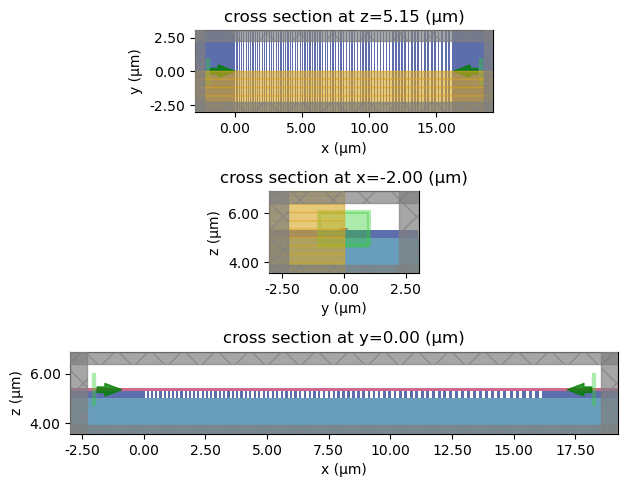

Grid size (22916400) and total time steps (43425) are within daily allowance.
Loaded path results from cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/half_hybrid_short_wavelength/8bbefa34d8e66adb07e4ea5a7fc4b06e1295dc9aa1bf7e844584c22fc96182da.dill


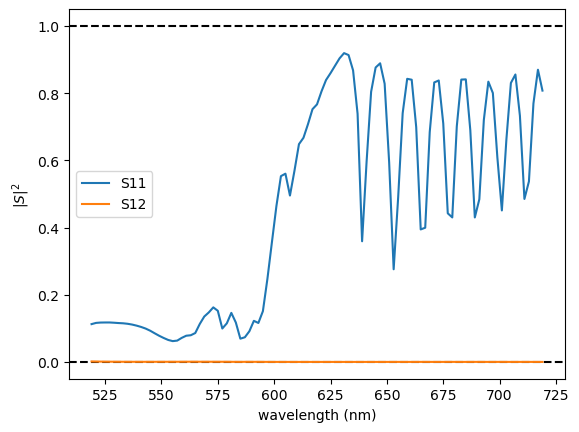

In [6]:

half_hybrid_path_short = HalfHybridPath(custom_modeler='short_wavelength')
journey.add_path(half_hybrid_path_short)
journey.validate_paths()
half_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
sp = journey.run_path('half_hybrid_short_wavelength', verbose=True)

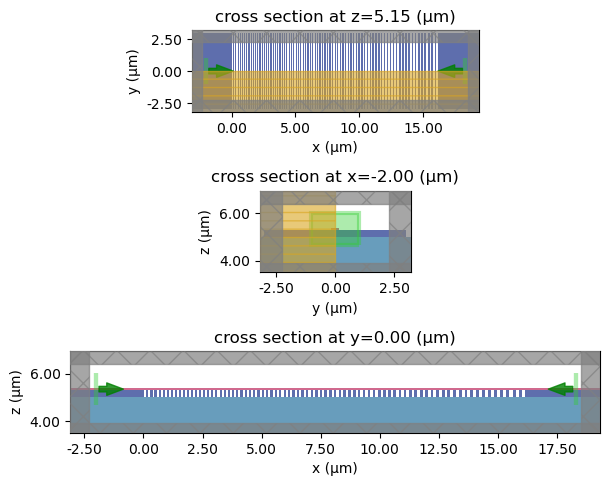

Grid size (15709641) and total time steps (45638) are within daily allowance.
Loaded path results from cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/half_hybrid_long_wavelength/2d1cd67c811900f3f8249e54966a776e38d4dcfdf0545fdef50f7c054fb5ee54.dill


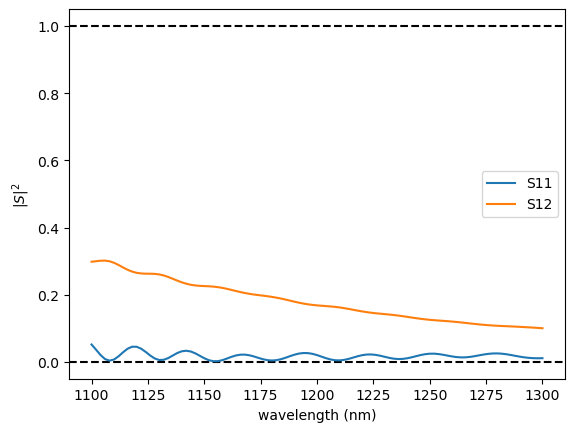

In [7]:

half_hybrid_path_short = HalfHybridPath(custom_modeler='long_wavelength')
journey.add_path(half_hybrid_path_short)
half_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
sp = journey.run_path('half_hybrid_long_wavelength', verbose=True)

## Full Hybrid Simulation

In [ ]:
class FullHybridPath(GDS_Tidy3DPath):
    @property
    def name(self) -> str:
        """Unique name of the path"""
        return self.custom_fdtd + '_' + self.custom_modeler
    @property
    def env_names(self) -> list[str]:
        """List of required environment names"""
        return ['full_hybrid', 'hybrid', 'materials'] + super().env_names
    
    def get_component(self, envs: dict[str, JEnv]):
        return pm.devices.hybrid_cavity(**envs['full_hybrid'].get_stripped_params(), **envs['hybrid'].get_stripped_params())

    def ponder(self, envs: dict[str, JEnv], data):
        fig, ax1 = plt.subplots(1, 1, tight_layout=True, figsize=(8, 4))
        ax1.plot(
            data.monitor_data["o1@dipole_Ey"].Ey.t * 1e12,
            np.real(data.monitor_data["o1@dipole_Ey"].Ey.squeeze()),
        )
        ax1.set_title("FieldTimeMonitor data")
        ax1.set_xlabel("time (ps)")
        ax1.set_ylabel("Real{Ey}")
        plt.show()

        wl_min, wl_max = envs[self.custom_modeler]['wavelength']-envs['modeler']['bandwidth']/2, envs[self.custom_modeler]['wavelength']+envs['modeler']['bandwidth']/2
        fmin, fmax = td.C_0 / wl_max, td.C_0 / wl_min
        resonance_finder = ResonanceFinder(freq_window=(fmin, fmax))
        resonance_data = resonance_finder.run(signals=data['o1@dipole_Ey'])
        print(resonance_data.to_dataframe())

### Long Wavelength

In [ ]:
full_hybrid_path_long = FullHybridPath(custom_modeler='long_wavelength', custom_fdtd='full_hybrid_fdtd')
journey.add_path(full_hybrid_path_long)
journey.validate_paths()
full_hybrid_path_long.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
data_long = journey.run_path(full_hybrid_path_long.name, verbose=True)

KeyboardInterrupt: 

### Short Wavelength

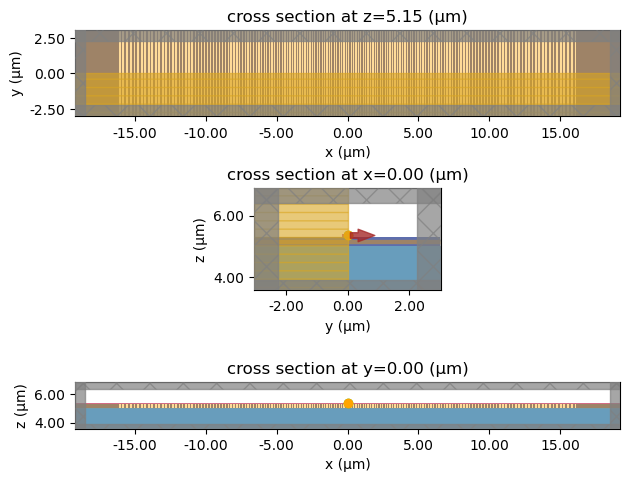

Grid size (39645372) and total time steps (43420) are within daily allowance.


11:32:10 EDT Created task 'full_hybrid_fdtd_short_wavelength' with task_id      
             'fdve-314204d7-2663-4a9a-995e-e1d0a8026fee' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=920205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=337600;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\taskId]8;;\]8;id=920205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\=]8;;\]8;id=334236;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\fdve]8;;\]8;id=920205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\-314204d7-266]8;;\
             ]8;id=920205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\3-4a9a-995e-e1d0a8026fee']8;;\.

             Task folder: ]8;id=134628;https://tidy3d.simulation.cloud/folders/folder-bccaf066-eccf-4061-aafb-95fe2ab09b26\'default']8;;\.

Output()

11:32:11 EDT Maximum FlexCredit cost: 0.953. Minimum cost depends on task       
             execution details. Use 'web.real_cost(task_id)' to get the billed  
             FlexCredit cost after a simulation run.

11:32:12 EDT status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

11:33:11 EDT You are running this simulation for FREE. Your current plan allows 
             up to 20 free non-concurrent simulations per day (under 100.0M grid
             points and 50.0K time steps)

             starting up solver

             running solver

Output()

11:34:37 EDT status = postprocess

Output()

11:34:39 EDT status = success

11:34:41 EDT View simulation result at                                          
             ]8;id=950379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=501608;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\taskId]8;;\]8;id=950379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\=]8;;\]8;id=542618;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\fdve]8;;\]8;id=950379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\-314204d7-266]8;;\
             ]8;id=950379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-314204d7-2663-4a9a-995e-e1d0a8026fee\3-4a9a-995e-e1d0a8026fee']8;;\.

Output()

11:34:43 EDT loading simulation from simulation_data.hdf5

             WARNING: Simulation final field decay value of 0.0161 is greater   
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

Saved path results to cache: /orcd/home/002/floresh2/file_system/git/JourneyMAPS/src/jmaps/cache/hybrid_dev/full_hybrid_fdtd_short_wavelength/04d8d26f288cd64fc54fd4dbd47630281ac353f7ce383d19725602cdbd5ca9bd.dill


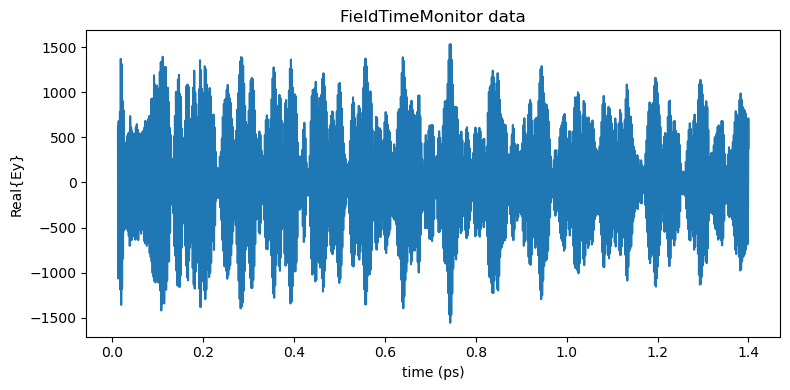

                     decay             Q   amplitude     phase     error
freq                                                                    
3.950564e+14 -3.235061e+11  -3836.423595   18.586477  2.358625  0.043958
4.119726e+14  5.586876e+11   2316.589759   47.424371  1.512867  0.025311
4.180985e+14  8.037319e+11   1634.245616   53.493306  1.203241  0.035112
4.246600e+14  8.840687e+11   1509.055293   66.723266  0.827241  0.010465
4.314399e+14  7.677190e+11   1765.500793   71.272081  0.398555  0.020830
4.386719e+14  5.458341e+11   2524.812132   82.944276  0.144189  0.017921
4.463297e+14  2.186191e+11   6413.832834  100.919489 -0.130937  0.008413
4.546257e+14  1.036810e+11  13775.412529  118.554397 -0.550795  0.011035
4.640974e+14  6.038652e+10  24144.541745  167.673497 -0.994139  0.018322
4.680659e+14  4.475766e+12    328.540960   14.235092 -1.179421  0.073957
4.743002e+14  6.383943e+12    233.407144   62.629135 -2.601337  0.164130
4.749172e+14  3.302981e+11   4517.121093  349.90007

In [ ]:
full_hybrid_path_short = FullHybridPath(custom_modeler='short_wavelength', custom_fdtd='full_hybrid_fdtd')
journey.add_path(full_hybrid_path_short)
journey.validate_paths()
full_hybrid_path_short.plot_geom(journey.envs, layer_name='nitride')
# half_hybrid_path_short.plot_mode(journey.envs)
data_short = journey.run_path(full_hybrid_path_short.name, verbose=True)